##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

## Setup

In [2]:
!pip install -q tensorflow_datasets

In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'For my humanities quarter project for school, i chose to do human trafficking. After some research on the internet, i found this DVD and ordered it. I just finished watching it and I am still thinking about it. All I can say is "Wow". It is such a compelling story of a 12 year old Vietnamese girl named Holly and an American man named Patric who tries to save her. The ending leaves you breathless, and although it\'s not a happily-ever-after ending, it is very realistic. It is amazing and I recommend it to anyone! You really connect with Holly and Patric and your heart breaks for her and because of what happens to her. I loved it so much and now I want to know what happens next!'
 b'I would rather of had my eyes gouged out with rusty ice picks than have had to sit through this abortion. There is no plot. There is no acting ability . Ray Liota has shamed himself and should be blacklisted from any more work. I am so sorry that the industry allows crap like this to be shown on an

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [10]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 16,  56,   1, ...,   0,   0,   0],
       [ 10,  59, 239, ...,   0,   0,   0],
       [142,  22, 243, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'For my humanities quarter project for school, i chose to do human trafficking. After some research on the internet, i found this DVD and ordered it. I just finished watching it and I am still thinking about it. All I can say is "Wow". It is such a compelling story of a 12 year old Vietnamese girl named Holly and an American man named Patric who tries to save her. The ending leaves you breathless, and although it\'s not a happily-ever-after ending, it is very realistic. It is amazing and I recommend it to anyone! You really connect with Holly and Patric and your heart breaks for her and because of what happens to her. I loved it so much and now I want to know what happens next!'
Round-trip:  for my [UNK] [UNK] [UNK] for school i [UNK] to do human [UNK] after some [UNK] on the [UNK] i found this dvd and [UNK] it i just [UNK] watching it and i am still thinking about it all i can say is [UNK] it is such a [UNK] story of a [UNK] year old [UNK] girl named [UNK] and an american 

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00438976]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00438976]


Compile the Keras model to configure the training process:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 361s 923ms/step - loss: 0.6632 - accuracy: 0.5279 - val_loss: 0.5402 - val_accuracy: 0.6740
Epoch 2/10
391/391 [==============================] - 354s 907ms/step - loss: 0.4287 - accuracy: 0.7930 - val_loss: 0.4049 - val_accuracy: 0.7797
Epoch 3/10
391/391 [==============================] - 358s 916ms/step - loss: 0.3471 - accuracy: 0.8462 - val_loss: 0.3377 - val_accuracy: 0.8422
Epoch 4/10
391/391 [==============================] - 357s 912ms/step - loss: 0.3245 - accuracy: 0.8558 - val_loss: 0.3301 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 432s 1s/step - loss: 0.3143 - accuracy: 0.8635 - val_loss: 0.3239 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 463s 1s/step - loss: 0.3092 - accuracy: 0.8652 - val_loss: 0.3241 - val_accuracy: 0.8443
Epoch 7/10
391/391 [==============================] - 401s 1s/step - loss: 0.3033 - accuracy: 0.8703 - val_loss: 0.3220 - val_accu

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 92s 236ms/step - loss: 0.3168 - accuracy: 0.8534
Test Loss: 0.3167927861213684
Test Accuracy: 0.8533999919891357


(0.0, 0.6815897211432457)

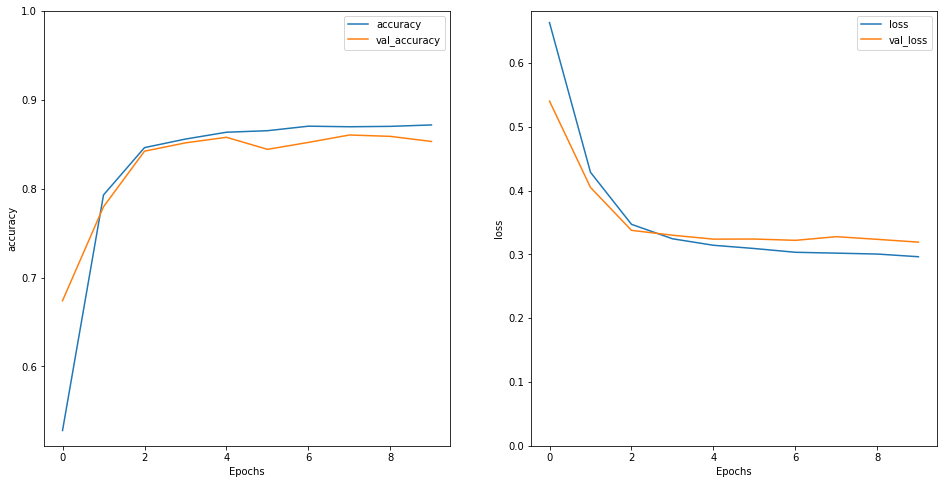

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.7236806]], dtype=float32)

In [67]:
# model.save_weights('../raw-data/lstm-model-v1')

In [19]:
model.load_weights('../raw-data/lstm-model-v1')

---

## Explanation

In [21]:
from anchor import anchor_text
import spacy

In [22]:
nlp = spacy.load('en_core_web_lg')

In [24]:
explainer = anchor_text.AnchorText(nlp, ['negative','positive'], use_unk_distribution=False)

In [25]:
anchor_text.AnchorText.__init__.__code__.co_varnames

('self', 'nlp', 'class_names', 'use_unk_distribution', 'mask_string')

In [26]:
# this is the requested function by Anchors!

def predict_text(text):
    return model.predict(text)[0]

def predict_text_alias(text):
    prediction = model.predict(np.array([text]))
    return "positive" if prediction[0][0] >= 0 else "negative"


In [27]:
text = 'terribly film became uncertainly positive'
pred = explainer.class_names

In [28]:
pred

['negative', 'positive']

In [29]:
text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

In [30]:
text = 'The movie was out of this world'

In [31]:
exp = explainer.explain_instance(text, predict_text, threshold=0.8, verbose=False, use_proba=True)

In [32]:
' AND '.join(exp.names())

'world AND movie AND out AND this AND of AND was AND The'

In [33]:
exp.examples()

array([['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world']], dtype='<U80')

---